In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

df_delta = pd.read_csv("Data Initial - Delta.csv")
df_aa = pd.read_csv("Data Initial - American.csv")
df_sw = pd.read_csv("Data Initial - Southwest.csv")
df_united = pd.read_csv("Data Initial - United.csv")
df_gas = pd.read_csv("Data Initial - Gas Imports.csv")
df_index = pd.read_csv("Data Initial - Indices.csv")
df_bts = pd.read_csv("BTS.csv")

In [2]:
#artifical variables
df_data = pd.DataFrame()
df_data['per_prem'] = df_index['ARTTPTDM']/(df_index['ARTTPTDM']+df_index['ARTTNTDM'])

df_data['avg_fare'] = df_index['ARTTNADM']*(1-df_data['per_prem']) + df_index['ARTTPADM']*(df_data['per_prem'])
df_data = df_data.join(df_index[['Year','Month','CO1_Comdty','CONSSENT','NAPMPMI','JETS_ETF']])

#opec
df_opec = pd.read_csv("OPEC.csv")
df_opec.rename({'Non-OPEC_Imports': 'Non_OPEC_Imports'}, axis=1, inplace=True)
df_data = df_data.join(df_opec)

#delta
df_delta.rename({'EPS_Estimate ': 'EPS_Estimate'}, axis=1, inplace=True)

df_data = df_data.join(df_delta[['Headcount','Attrition','TotalPageView',
       'PageViewPerUser','EPS_Estimate','android_users','ipad_users','iphone_users']])

#bts
df_data = df_data.join(df_bts[['total_flights','total_passengers']])

#dropna
df_no_na = df_data.dropna()

#drop last two rows
df_no_na = df_no_na.drop(df_no_na.tail(2).index)



In [3]:
df_no_na.head()

,per_prem,avg_fare,Year,Month,CO1_Comdty,CONSSENT,NAPMPMI,JETS_ETF,Non_OPEC_Imports,OPEC_Imports,Headcount,Attrition,TotalPageView,PageViewPerUser,EPS_Estimate,android_users,ipad_users,iphone_users,total_flights,total_passengers
159,0.056717,443.629923,2016,1,34.74,92.0,47.6,22.32,206242.0,94673.0,93765.32,0.06,3217.3,6.48,1.32,441002.0,65573.0,891181.0,56688017.0,571158.0
160,0.058940,439.927796,2016,2,35.97,91.7,49.2,24.15,198250.0,93665.0,93912.82,0.06,3016.4,6.43,1.32,435948.0,61213.0,894047.0,54508230.0,548066.0
161,0.059136,411.299464,2016,3,39.60,91.0,51.0,25.36,199181.0,110857.0,94274.58,0.06,3343.9,6.45,1.27,445917.0,59021.0,925530.0,65812477.0,626067.0
162,0.056894,432.221529,2016,4,48.13,89.0,51.3,23.69,194050.0,100609.0,94507.90,0.06,3024.4,6.36,1.85,437927.0,58687.0,927141.0,62761040.0,605520.0
163,0.057075,436.174656,2016,5,49.69,94.7,51.4,23.00,201990.0,113610.0,94986.32,0.06,3340.7,6.27,1.85,455903.0,56848.0,969270.0,66892186.0,630539.0


In [4]:
#lag
df_data_lag = df_no_na[['Year','Month']].join(df_no_na[['per_prem','avg_fare','CO1_Comdty', 'CONSSENT',
       'NAPMPMI', 'Non_OPEC_Imports', 'OPEC_Imports',
       'Headcount', 'Attrition', 'TotalPageView', 'PageViewPerUser',
       'android_users','ipad_users','iphone_users', 'total_flights','total_passengers']].pct_change(axis=0,fill_method = 'bfill').shift(1))

df_data_lag = df_data_lag.join(df_no_na[['EPS_Estimate']].pct_change(axis=0,fill_method='bfill'))

#year/quarter
df_data_lag['Year-Quarter'] = df_data_lag['Year'].astype(str) + '-Q' + np.ceil(df_data_lag.Month/3).astype(str)
df_data_lag['Year-Quarter'] = df_data_lag['Year-Quarter'].str[:-2]

df_data_lag['q'] = df_data_lag['Year-Quarter'].str[-2:]

#dummies
df_data_lag = pd.get_dummies(df_data_lag, columns=['q'],drop_first=True)

#drop
all_columns = " + ".join(df_data_lag.drop(columns = ['EPS_Estimate','Year-Quarter','Year','Month']).columns)

#covid
import numpy as np

conditions = [
    (df_data_lag['Month'] > 2) & (df_data_lag['Year'] == 2020) | (df_data_lag['Year'] > 2020)
    ]

values = [1]

df_data_lag['covid'] = np.select(conditions, values)
df_lag_drop_na = df_data_lag.dropna()
df_lag_drop_na = df_lag_drop_na.drop(df_lag_drop_na.head(1).index)

df_lag_drop_na.tail()

,Year,Month,per_prem,avg_fare,CO1_Comdty,CONSSENT,NAPMPMI,Non_OPEC_Imports,OPEC_Imports,Headcount,Attrition,TotalPageView,PageViewPerUser,android_users,ipad_users,iphone_users,total_flights,total_passengers,EPS_Estimate,Year-Quarter,q_Q2,q_Q3,q_Q4,covid
225,2021,7,0.049384,0.017411,0.083814,0.031363,-0.011364,0.027160,0.241492,0.003963,0.000000,0.161791,-0.063395,0.168051,0.134966,0.189488,0.146134,0.092888,-1.305556,2021-Q3,0,1,0,1
226,2021,8,0.220674,-0.143679,0.015972,-0.050292,-0.016420,-0.028760,0.020743,0.003740,0.000000,0.041697,0.065502,0.048445,0.086961,0.075321,0.114816,0.080725,-0.022727,2021-Q3,0,1,0,1
227,2021,9,0.071555,-0.014221,-0.043757,-0.134236,-0.003339,-0.000634,-0.067692,0.003232,-0.111111,-0.125440,-0.055328,0.036149,-0.040889,-0.070613,-0.092229,-0.016236,-0.581395,2021-Q3,0,1,0,1
228,2021,10,0.049781,0.093648,0.075764,0.035562,0.013400,0.007517,-0.117154,-0.001462,0.000000,-0.001048,0.017354,-0.093800,-0.037171,-0.033399,-0.122207,-0.073986,-2.444444,2021-Q4,0,0,1,1
229,2021,11,-0.048535,0.095391,0.074631,-0.015110,0.004959,-0.070283,0.020569,0.002053,0.000000,0.037348,0.000000,0.039332,-0.011847,-0.043632,0.029711,-0.035495,0.000000,2021-Q4,0,0,1,1


In [5]:
df_lag_drop_na.tail()

,Year,Month,per_prem,avg_fare,CO1_Comdty,CONSSENT,NAPMPMI,Non_OPEC_Imports,OPEC_Imports,Headcount,Attrition,TotalPageView,PageViewPerUser,android_users,ipad_users,iphone_users,total_flights,total_passengers,EPS_Estimate,Year-Quarter,q_Q2,q_Q3,q_Q4,covid
225,2021,7,0.049384,0.017411,0.083814,0.031363,-0.011364,0.027160,0.241492,0.003963,0.000000,0.161791,-0.063395,0.168051,0.134966,0.189488,0.146134,0.092888,-1.305556,2021-Q3,0,1,0,1
226,2021,8,0.220674,-0.143679,0.015972,-0.050292,-0.016420,-0.028760,0.020743,0.003740,0.000000,0.041697,0.065502,0.048445,0.086961,0.075321,0.114816,0.080725,-0.022727,2021-Q3,0,1,0,1
227,2021,9,0.071555,-0.014221,-0.043757,-0.134236,-0.003339,-0.000634,-0.067692,0.003232,-0.111111,-0.125440,-0.055328,0.036149,-0.040889,-0.070613,-0.092229,-0.016236,-0.581395,2021-Q3,0,1,0,1
228,2021,10,0.049781,0.093648,0.075764,0.035562,0.013400,0.007517,-0.117154,-0.001462,0.000000,-0.001048,0.017354,-0.093800,-0.037171,-0.033399,-0.122207,-0.073986,-2.444444,2021-Q4,0,0,1,1
229,2021,11,-0.048535,0.095391,0.074631,-0.015110,0.004959,-0.070283,0.020569,0.002053,0.000000,0.037348,0.000000,0.039332,-0.011847,-0.043632,0.029711,-0.035495,0.000000,2021-Q4,0,0,1,1


In [6]:
from pathlib import Path  
filepath = Path('lagoon_file.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_lag_drop_na.to_csv(filepath)

# all_columns

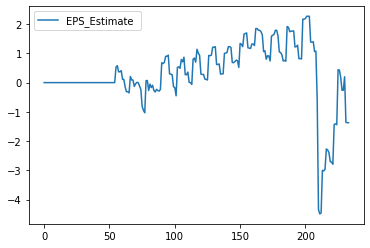

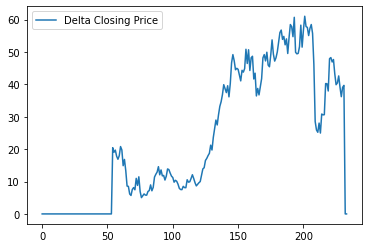

In [5]:
#EDA
from matplotlib import pyplot as plt
df_delta[['EPS_Estimate ']].dropna().plot()
df_delta[['Delta Closing Price']].dropna().plot()

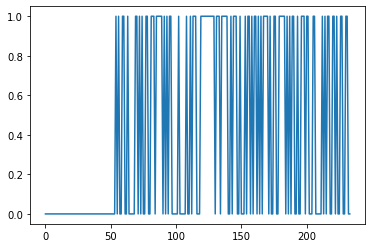

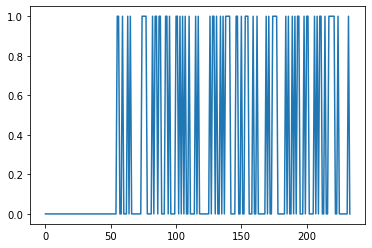

In [6]:
x= np.where(df_delta['Delta Closing Price'].pct_change() > 0, 1,0)
y= np.where(df_delta['EPS_Estimate '].pct_change() > 0, 1,0)
plt.plot(np.where(df_delta['Delta Closing Price'].pct_change() > 0, 1,0))
plt.show()


plt.plot(np.where(df_delta['EPS_Estimate '].pct_change() > 0, 1,0))
plt.show()

In [7]:
#preliminary regressions
import statsmodels.formula.api as smf
linear_reg = smf.ols('EPS_Estimate  ~' + all_columns, data = df_lag_drop_na).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           EPS_Estimate   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     4.069
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           3.45e-05
Time:                        22:29:56   Log-Likelihood:                -62.175
No. Observations:                  69   AIC:                             166.3
Df Residuals:                      48   BIC:                             213.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0813      0.215      0.379      0.706      -0.350       0.513
per_prem                 4.8997      1.716      2.856      0.006       1.450       8.349
avg_fare                 0.4309      1.693      0.254      0.800      -2.974       3.836
CO1_Comdty              -2.9106      0.981     -2.967      0.005      -4.883      -0.938
CONSSENT                -4.6235      2.349     -1.969      0.055      -9.346       0.099
NAPMPMI                  1.7935      3.257      0.551      0.584      -4.755       8.342
Non_OPEC_Import         -1.4797      1.744     -0.848      0.400      -4.987       2.027
OPEC_Imports             0.2943      0.765      0.384      0.702      -1.245       1.833
Passengers_Total        -3.3717      6.431     -0.524      0.602     -16.302       9.559
Headcount                1.4258     32.654      0.044      0.965     -64.229      67.081
Attrition                3.3079      1.649      2.006      0.051      -0.008       6.624
TotalPageView            2.5034      1.406      1.780      0.081      -0.324       5.330
PageViewPerUser         -2.5686      3.619     -0.710      0.481      -9.845       4.707
SeatMile_Total           3.6340      6.370      0.571      0.571      -9.173      16.441
Flight_Total             3.4010      7.634      0.446      0.658     -11.948      18.750
PassengerMiles_Total    -2.0405      6.375     -0.320      0.750     -14.859      10.778
Other_Pass               2.4920      1.457      1.710      0.094      -0.438       5.422
Other_Flights           -5.0231      1.997     -2.515      0.015      -9.039      -1.007
q_Q2                     0.6663      0.293      2.277      0.027       0.078       1.255
q_Q3                    -0.5689      0.313     -1.817      0.075      -1.199       0.061
q_Q4                    -0.2548      0.310     -0.823      0.415      -0.878       0.368
==============================================================================
Omnibus:                        6.496   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.426
Skew:                           0.315   Prob(JB):                       0.0148
Kurtosis:                       4.592   Cond. No.                         422.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
linear_reg = smf.ols('EPS_Estimate  ~' + all_columns, data = df_lag_drop_na[:25]).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           EPS_Estimate   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     4.324
Date:                Mon, 04 Apr 2022   Prob (F-statistic):             0.0825
Time:                        22:29:56   Log-Likelihood:                 35.206
No. Observations:                  25   AIC:                            -28.41
Df Residuals:                       4   BIC:                            -2.816
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2274      0.192      1.184      0.302      -0.306       0.761
per_prem                -0.7281      3.846     -0.189      0.859     -11.408       9.951
avg_fare                 6.7401      3.620      1.862      0.136      -3.309      16.790
CO1_Comdty              -1.6686      1.146     -1.456      0.219      -4.850       1.512
CONSSENT                -0.6132      1.861     -0.329      0.758      -5.781       4.554
NAPMPMI                 -0.1249      2.823     -0.044      0.967      -7.962       7.712
Non_OPEC_Import         -5.1571      2.637     -1.956      0.122     -12.479       2.165
OPEC_Imports            -0.4919      1.434     -0.343      0.749      -4.472       3.488
Passengers_Total       -28.6650     11.409     -2.512      0.066     -60.342       3.012
Headcount                5.8276     66.464      0.088      0.934    -178.706     190.362
Attrition                2.7088      1.128      2.401      0.074      -0.424       5.841
TotalPageView           -0.7705      0.807     -0.954      0.394      -3.012       1.471
PageViewPerUser         -6.5895      7.440     -0.886      0.426     -27.245      14.066
SeatMile_Total         -36.7163     19.372     -1.895      0.131     -90.500      17.068
Flight_Total            34.0280     13.000      2.618      0.059      -2.066      70.122
PassengerMiles_Total    21.8682      9.898      2.209      0.092      -5.613      49.349
Other_Pass               0.8455      6.852      0.123      0.908     -18.180      19.871
Other_Flights           18.1449     19.775      0.918      0.411     -36.759      73.049
q_Q2                     0.4482      0.464      0.966      0.389      -0.839       1.736
q_Q3                     0.0395      0.497      0.079      0.941      -1.341       1.420
q_Q4                    -1.0293      0.724     -1.422      0.228      -3.039       0.981
==============================================================================
Omnibus:                        0.910   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.912
Skew:                           0.331   Prob(JB):                        0.634
Kurtosis:                       2.338   Cond. No.                     2.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

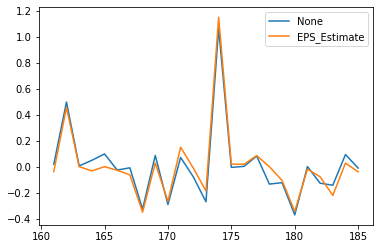

In [9]:
eps_pred = linear_reg.predict(df_lag_drop_na[:25])
eps_act = df_lag_drop_na['EPS_Estimate'][:25]
eps_pred.plot()
eps_act.plot()
plt.legend()

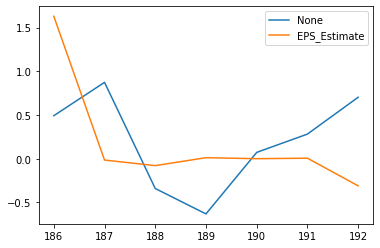

In [10]:
eps_pred = linear_reg.predict(df_lag_drop_na[25:32])
eps_act = df_lag_drop_na['EPS_Estimate'][25:32]
eps_pred.plot()
eps_act.plot()
plt.legend()

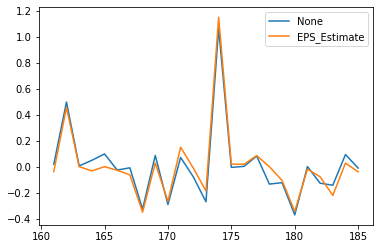

In [11]:
eps_pred = linear_reg.predict(df_lag_drop_na[:25])
eps_act = df_lag_drop_na['EPS_Estimate'][:25]
from matplotlib import pyplot as plt
eps_pred.plot()
eps_act.plot()
plt.legend()

In [13]:
# df_pred = pd.DataFrame()
# df_pred['q'] = df_lag_drop_na['Year-Quarter'][25:32]
# df_pred['Pred'] = linear_reg.predict(df_lag_drop_na[25:32])
# df_pred.groupby('q')['Pred'].agg(lambda x: (1+x).prod()).plot()
# df_lag_drop_na[25:32].groupby('Year-Quarter')['EPS_Estimate'].agg(lambda x: (1+x).prod()).plot()
# df_lag_drop_na[22:32].groupby('Year-Quarter').mean().pct_change()['Reported'].shift(-1).plot()
# plt.legend()

In [14]:
df_pred.groupby('q')['Pred'].agg(lambda x: (1+x).prod())

q
2018-Q2    1.841537
2018-Q3    0.505653
2018-Q4    1.702944
Name: Pred, dtype: float64

In [16]:
# eps_pred = linear_reg.predict(df_lag_drop_na[25:32])
# eps_act = df_lag_drop_na['EPS_Estimate'][25:32]
# df_lag_drop_na['Reported'][22:32].pct_change(3).plot()
# eps_pred.plot()
# eps_act.plot()
# plt.legend()

In [6]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.feature_selection import RFE

In [7]:
#linear regression RFE
y_linear_df = df_lag_drop_na['EPS_Estimate']
x_linear_df = df_lag_drop_na.drop(columns=['Year', 'Month','EPS_Estimate','Year-Quarter'])

#fit regression
df_vars = df_lag_drop_na.columns.values.tolist()
y = ['EPS_Estimate']
drop_vars = ['Year', 'Month','EPS_Estimate','Year-Quarter']
x = [i for i in df_vars if i not in drop_vars]

linreg = linear_model.LinearRegression()

rfe_lin = RFE(linreg)
rfe_lin = rfe_lin.fit(x_linear_df, y_linear_df.values.ravel())
bool_lin = rfe_lin.support_

#feature importance
rank_lin = list(rfe_lin.ranking_)
bool_lin = list(rfe_lin.support_)
del df_vars[:2]
del df_vars[-6:-4]

#signficant vars
significant_vars = pd.DataFrame(df_vars)
significant_vars['rank'] = rank_lin
significant_vars['bool'] = bool_lin
significant_vars.sort_values('rank')

,0,rank,bool
0,per_prem,1,True
19,Other_Flights,1,True
18,Other_Pass,1,True
17,iphone_users,1,True
13,Flight_Total,1,True
10,TotalPageView,1,True
9,Attrition,1,True
8,Headcount,1,True
11,PageViewPerUser,1,True
3,CONSSENT,1,True


In [9]:
df_direction_log = df_lag_drop_na
df_direction_log.head()

df_direction_log['EPS_Direction'] = np.where(df_direction_log['EPS_Estimate'] > 0, 1,0)
df_direction_log = df_direction_log.drop(columns=['EPS_Estimate'])
df_direction_log.head()


# filepath = Path('eps_direction_file.csv')  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# df_lag_drop_na.to_csv(filepath)


,Year,Month,per_prem,avg_fare,CO1_Comdty,CONSSENT,NAPMPMI,Non_OPEC_Import,OPEC_Imports,Passengers_Total,Headcount,Attrition,TotalPageView,PageViewPerUser,SeatMile_Total,Flight_Total,PassengerMiles_Total,android_users,ipad_users,iphone_users,Other_Pass,Other_Flights,Year-Quarter,q_Q2,q_Q3,q_Q4,covid,EPS_Direction
161,2016,3,0.039208,-0.008345,0.035406,-0.003261,0.033613,-0.038751,-0.010647,-0.036282,0.001573,0.0,-0.062444,-0.007716,-0.059214,-0.028884,-0.082873,-0.011460,-0.066491,0.003216,-0.049309,-0.041516,2016-Q1,0,0,0,0,0
162,2016,4,0.003314,-0.065075,0.100917,-0.007634,0.036585,0.004696,0.183548,0.219805,0.003852,0.0,0.108573,0.003110,0.164913,0.148638,0.237544,0.022867,-0.035809,0.035214,0.208320,0.140749,2016-Q2,1,0,0,0,1
163,2016,5,-0.037905,0.050868,0.215404,-0.021978,0.005882,-0.025760,-0.092443,-0.030104,0.002475,0.0,-0.095547,-0.013953,-0.001643,-0.020620,-0.020917,-0.017918,-0.005659,0.001741,-0.045860,-0.042845,2016-Q2,1,0,0,0,0
164,2016,6,0.003170,0.009146,0.032412,0.064045,0.001949,0.040917,0.129223,0.082149,0.005062,0.0,0.104583,-0.014151,0.067898,0.049047,0.092898,0.041048,-0.031336,0.045440,0.066266,0.040287,2016-Q2,1,0,0,0,0
165,2016,7,0.045860,-0.034627,-0.000201,-0.012672,0.015564,0.002673,-0.127762,0.029488,0.001585,0.0,0.032718,0.015949,0.050735,0.020351,0.082961,0.022288,-0.021461,0.045008,0.041806,0.018160,2016-Q3,0,1,0,0,0


In [10]:

#rfe
y_log_df = df_direction_log['EPS_Direction']
x_log_df = df_direction_log.drop(columns=['Year', 'Month','EPS_Direction','Year-Quarter'])

df_vars_log = df_direction_log.columns.values.tolist()
y_log = ['EPS_Direction']
drop_log_vars = ['Year', 'Month','EPS_Estimate','Year-Quarter']
x_log = [i for i in df_vars_log if i not in drop_log_vars]

logreg = linear_model.LogisticRegression()

rfe_log = RFE(logreg)
rfe_log = rfe_log.fit(x_log_df, y_log_df.values.ravel())
bool_log = rfe_log.support_

rank_log = list(rfe_log.ranking_)
bool_log = list(rfe_log.support_)
del df_vars_log[:2]
del df_vars_log[-6:-4]

#significant vars
significant_vars = pd.DataFrame(df_vars_log)
significant_vars['rank'] = rank_log
significant_vars['bool'] = bool_log
significant_vars.sort_values('rank')

,0,rank,bool
1,avg_fare,1,True
2,CO1_Comdty,1,True
3,CONSSENT,1,True
21,q_Q4,1,True
20,q_Q3,1,True
6,OPEC_Imports,1,True
18,Other_Pass,1,True
16,ipad_users,1,True
9,Attrition,1,True
14,PassengerMiles_Total,1,True


In [21]:
# significant_vars[significant_vars['bool'] == False]
# list(signiaficant_vars.loc[significant_vars['bool'] == False, 0])

In [16]:
from sklearn.model_selection import train_test_split

log_train, log_test = train_test_split(df_direction_log, test_size = 0.3)

x_log_train = log_train.iloc[0:,0:27]

y_log_train = log_train.iloc[0:,27]

x_log_test = log_test.iloc[0:,0:27]

y_log_test = log_test.iloc[0:,27]

In [17]:
x_log_train = x_log_train.drop(columns=['Year','Month','Year-Quarter'])
x_log_train.head()

,per_prem,avg_fare,CO1_Comdty,CONSSENT,NAPMPMI,Non_OPEC_Import,OPEC_Imports,Passengers_Total,Headcount,Attrition,TotalPageView,PageViewPerUser,SeatMile_Total,Flight_Total,PassengerMiles_Total,android_users,ipad_users,iphone_users,Other_Pass,Other_Flights,q_Q2,q_Q3,q_Q4,covid
229,-0.048535,0.095391,0.074631,-0.015110,0.004959,-0.070283,0.020569,0.095398,0.002053,0.0,0.037348,0.000000,0.037083,0.047296,0.083799,0.039332,-0.011847,-0.043632,0.100043,-0.043872,0,0,1,1
204,-0.020299,0.023392,0.005792,0.037862,-0.008247,-0.109328,-0.066954,-0.144848,-0.002178,0.0,-0.270841,-0.055351,-0.133654,-0.110324,-0.170306,-0.029891,-0.049574,-0.066092,-0.130216,-0.082269,0,0,1,0
192,0.010200,0.018055,0.068458,0.040541,-0.019835,-0.119590,0.014758,-0.168386,-0.000543,0.0,-0.192195,-0.067010,-0.143880,-0.118672,-0.186305,-0.046738,-0.022533,-0.048897,-0.152591,-0.084707,0,0,1,0
202,0.061781,-0.027030,-0.020736,0.002037,-0.009709,0.112615,-0.136350,0.035787,0.000982,0.0,0.083315,-0.007380,0.054344,0.037186,0.049177,0.032895,-0.012703,0.062133,0.036457,0.038736,0,1,0,0
174,0.020603,0.023279,-0.049649,0.006231,-0.020797,0.107534,0.154692,0.281497,0.004983,0.2,0.268406,0.049917,0.219231,0.205012,0.288699,0.061462,0.004433,0.118429,0.246601,0.186235,1,0,0,0


In [18]:
x_log_test = x_log_test.drop(columns=['Year','Month','Year-Quarter'])
x_log_test.head()

,per_prem,avg_fare,CO1_Comdty,CONSSENT,NAPMPMI,Non_OPEC_Import,OPEC_Imports,Passengers_Total,Headcount,Attrition,TotalPageView,PageViewPerUser,SeatMile_Total,Flight_Total,PassengerMiles_Total,android_users,ipad_users,iphone_users,Other_Pass,Other_Flights,q_Q2,q_Q3,q_Q4,covid
168,0.019164,0.000617,0.042942,0.015590,0.026104,-0.070300,0.009583,-0.084948,0.000515,0.000000,-0.295805,-0.057489,-0.138960,-0.099142,-0.136725,-0.052522,-0.061028,-0.047384,-0.095634,-0.082155,0,0,1,0
211,-0.070050,0.098749,0.111258,-0.194164,-0.152749,-0.155975,-0.215647,-0.924753,-0.009900,0.000000,-0.712902,-0.186253,-0.802616,-0.738980,-0.928972,-0.314327,-0.284752,-0.286424,-0.920880,-0.633903,1,0,0,1
161,0.039208,-0.008345,0.035406,-0.003261,0.033613,-0.038751,-0.010647,-0.036282,0.001573,0.000000,-0.062444,-0.007716,-0.059214,-0.028884,-0.082873,-0.011460,-0.066491,0.003216,-0.049309,-0.041516,0,0,0,0
208,-0.069056,0.017799,-0.118788,0.005035,0.073069,-0.012281,-0.343609,-0.075540,0.006655,0.000000,0.031268,-0.008584,0.009880,-0.007760,-0.053212,-0.014996,-0.001432,0.001763,-0.106705,-0.048489,0,0,0,0
199,-0.007652,0.018312,0.064483,-0.012195,-0.023679,0.060592,-0.077488,-0.040237,0.002948,0.166667,-0.072203,0.001838,-0.013680,-0.029300,-0.027333,-0.016439,-0.004706,0.004657,-0.043286,-0.038387,1,0,0,0


In [19]:
def get_classification(predictions,threshold):
    #
    classes = np.zeros_like(y_pred_prob)
    #the shape of testing predictions > 
    
    for i in range(len(classes)):
        if predictions[i] > threshold:
            #i is going to be 0 the first time, then look to first prediction 
            #set classes i to be 1 > intialized classes to be a bunch of zeros 
            classes[i] = 1
    return classes

In [20]:
lr_model=linear_model.LogisticRegression(max_iter=10000,random_state=101,multi_class='ovr',solver='lbfgs',class_weight='balanced',C=10)
lr_model.fit(x_log_df, y_log_df.values.ravel())

y_pred_prob = lr_model.predict_proba(x_log_test)[:,1]
y_log_pred = get_classification(y_pred_prob,0.50)



print('AUC: %.4f' % metrics.roc_auc_score(y_log_test, y_log_pred))
print('Accuracy: %.4f' % metrics.accuracy_score(y_log_test, y_log_pred))
print('Recall: %.4f' % metrics.recall_score(y_log_test, y_log_pred))
print('F1-score: %.4f' %metrics.f1_score(y_log_test, y_log_pred))
print('Precision: %.4f' %metrics.precision_score(y_log_test, y_log_pred))
print('R2:  %.4f' %metrics.r2_score(y_log_test, y_log_pred))

metrics.confusion_matrix(y_log_test, y_log_pred)

AUC: 0.5577
Accuracy: 0.5714
Recall: 0.5000
F1-score: 0.4706
Precision: 0.4444
R2:  -0.8173


array([[8, 5],
       [4, 4]])

In [21]:
x_columns = " + ".join(df_direction_log.drop(columns = ['EPS_Direction','Year-Quarter','Year','Month','per_prem',
 'NAPMPMI',
 'Non_OPEC_Import',
 'OPEC_Imports',
 'Headcount',
 'Attrition',
 'PageViewPerUser',
 'Other_Pass',
 'q_Q4',
 'covid']).columns) 
x_columns

'avg_fare + CO1_Comdty + CONSSENT + Passengers_Total + TotalPageView + SeatMile_Total + Flight_Total + PassengerMiles_Total + android_users + ipad_users + iphone_users + Other_Flights + q_Q2 + q_Q3'

In [22]:
import statsmodels.formula.api as smf

logistic_reg = smf.logit('EPS_Direction ~' + x_columns, data=df_direction_log).fit()
#outcome is dependent and rate is independnet - get coefficients a and b

logistic_reg.summary()

Optimization terminated successfully.
         Current function value: 0.500707
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          EPS_Direction   No. Observations:                   69
Model:                          Logit   Df Residuals:                       54
Method:                           MLE   Df Model:                           14
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                  0.2519
Time:                        13:05:46   Log-Likelihood:                -34.549
converged:                       True   LL-Null:                       -46.184
Covariance Type:            nonrobust   LLR p-value:                   0.05602
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1161      0.456     -0.255      0.799      -1.010       0.777
avg_fare                -3.9145      4.977     -0.786      0.432     -13.670       5.841
CO1_Comdty              -5.4041      3.713     -1.456      0.146     -12.681       1.873
CONSSENT               -21.5206      8.647     -2.489      0.013     -38.468      -4.573
Passengers_Total       -18.3679     17.452     -1.052      0.293     -52.574      15.838
TotalPageView            0.3676      4.484      0.082      0.935      -8.421       9.156
SeatMile_Total          -6.1048     21.058     -0.290      0.772     -47.378      35.168
Flight_Total             9.0886     22.070      0.412      0.680     -34.169      52.346
PassengerMiles_Total    23.0212     22.439      1.026      0.305     -20.959      67.001
android_users          -15.3026      9.649     -1.586      0.113     -34.214       3.608
ipad_users               3.2752      2.351      1.393      0.164      -1.332       7.882
iphone_users            12.8660      9.492      1.356      0.175      -5.737      31.469
Other_Flights           -4.9149      5.236     -0.939      0.348     -15.177       5.348
q_Q2                     0.4584      0.784      0.584      0.559      -1.079       1.996
q_Q3                    -2.5773      1.042     -2.472      0.013      -4.620      -0.534
========================================================================================
"""